In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
import random

In [2]:
df = pd.read_csv('nacas.csv')
np.unique(df['naca'])

array(['0006', '0008', '000834', '0010', '001034', '001035', '001064',
       '001065', '001066', '001234', '001264', '0015', '0018', '0021',
       '0024', '1408', '1410', '1412', '16006', '16009', '16012', '16015',
       '16018', '16021', '23012', '23015', '23018', '23021', '23024',
       '2408', '2410', '2411', '2412', '2415', '2418', '2421', '2424',
       '4412', '4415', '4418', '4421', '4424', '63206', '63209', '632615',
       '632a015', '633018', '633218', '633418', '633618', '634221',
       '634421', '63a210', '641112', '6412', '64206', '64208', '64209',
       '64210', '642215', '642415', '643218', '643418', '643618',
       '644221', '644421', '64a010', '64a210', '64a410', '651212',
       '651212a06', '651412', '65206', '65209', '65210', '652215',
       '652415', '652415a05', '653218', '65410', '654221', '654421',
       '654421a05', '66-018', '661212', '66206', '66209', '66210',
       '662215', '662415', '663218', '663418', '664221', '671215',
       '747a315', '747a4

In [3]:
df = pd.read_csv('nacas.csv')
NACAS = ['4415','4412','6412','2411', 'clarky']
df = df.loc[(df['naca'] == '4415') | (df['naca'] == '4412') | (df['naca'] == '6412') | (df['naca'] == '2411') | (df['naca'] == 'clarky')]

In [4]:
def Cx_data(naca, reynolds):
    return np.array(df.loc[(df['naca']==naca) & (df['reynolds'] == reynolds)]['CD'])

def Cz_data(naca, reynolds):
    return np.array(df.loc[(df['naca']==naca) & (df['reynolds'] == reynolds)]['CL'])

def Alpha_data(naca, reynolds):
    return np.array(df.loc[(df['naca']==naca) & (df['reynolds'] == reynolds)]['alpha'])

Text(0.5, 1.0, 'Cz 4412 discret')

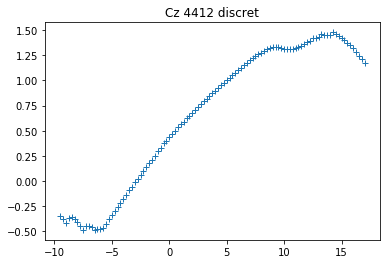

In [5]:
x = Alpha_data('4412', 100000)
y = Cz_data('4412',100000)
plt.plot(x,y,"+")
plt.title('Cz 4412 discret')

In [6]:
spl = InterpolatedUnivariateSpline(x, y, k=5)

Text(0.5, 1.0, 'Comparaison Cz 4412 interpolé / discret')

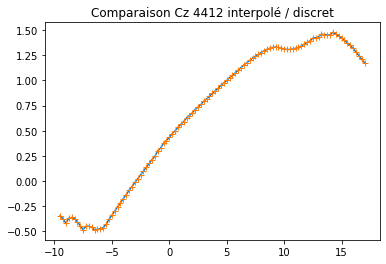

In [7]:
plt.plot(x,spl(x))
plt.plot(x,y,"+")
plt.title('Comparaison Cz 4412 interpolé / discret')

Text(0.5, 1.0, 'Comparaison Cz 4412 interpolé / discret')

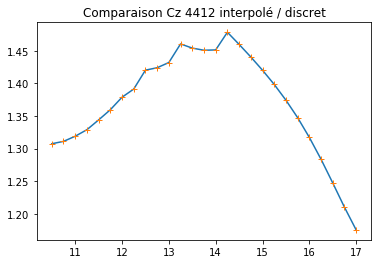

In [8]:
plt.plot(x[80:],spl(x[80:]))
plt.plot(x[80:],y[80:],"+")
plt.title('Comparaison Cz 4412 interpolé / discret')

In [9]:
def Cx_spline(naca, reynolds):
    x = Alpha_data(naca, reynolds)
    y = Cx_data(naca,reynolds)
    spl = InterpolatedUnivariateSpline(x, y, k=5, ext = 3)
    return spl

def Cz_spline(naca, reynolds):
    x = Alpha_data(naca, reynolds)
    y = Cz_data(naca,reynolds)
    spl = InterpolatedUnivariateSpline(x, y, k=5, ext = 3)
    return spl

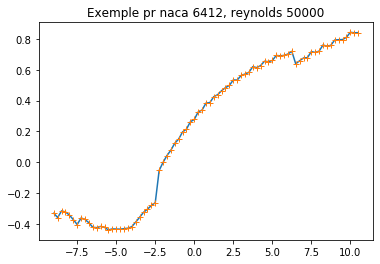

In [10]:
plt.title('Exemple pr naca 6412, reynolds 50000')
plt.plot(Alpha_data('6412',50000),Cz_spline('6412',50000)(Alpha_data('6412',50000)))
plt.plot(Alpha_data('6412',50000),Cz_data('6412',50000),"+")

In [11]:
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time
import random
from scipy.interpolate import interp1d

In [12]:
def simu(naca = '4412', N_elements = 50, r_min = 0.01, r_max = 0.06):

    # Créations des fonctions continues Cx, Cz
    func_Cx = dict()
    func_Cz = dict()
    for reynolds in [50000, 100000, 200000, 500000, 1000000]:
        func_Cx[str(reynolds)] = Cx_spline(naca, reynolds)
        func_Cz[str(reynolds)] = Cz_spline(naca, reynolds)

    # Discrétisation des rayons
    rayons = np.linspace(r_min, r_max, N_elements)

    # Calcul du pas associé
    delta = rayons[1]-rayons[0]

    n = 10000/60

    # Vitesse de flux d'air en vol stat définie par Froude : (sqrt(mg/8rhoS) pour une hélice entière)

    v_froude = np.sqrt(0.5 * 9.81 / (8 * 1.3 * (r_max**2-r_min**2)* np.pi))

    # Angle dû à la vitesse "froude"

    def beta(r):
        angle_rad = np.arctan(v_froude/(2*np.pi*n*r))
        angle_deg = angle_rad/np.pi*180
        return angle_deg

    # Fonction de vitesse
    def speed(r):
        v_t = 2*np.pi*r*n
        return np.sqrt(v_froude**2+v_t**2)

    # Fonction de surface d'un trapèze
    def area(l1, l2):
        return (np.abs(l1)+np.abs(l2))/2 * delta

    # Plus proche voisin d'un élément dans une liste

    def NN(element, L):
        l = len(L)
        cand = 0
        tol = np.abs(L[cand])+np.abs(element)
        for k in range(l):
            if np.abs(L[k]-element)<tol:
                cand = k
                tol = np.abs(L[k]-element)
        return cand

    # Fonction qui associe le Reynolds le plus proche du vrai Reynolds :

    def Reynolds(vitesse, L_c):
        mu = 1.56 * 10**-5
        all_reys = [50000,100000,500000,1000000]
        return all_reys[NN(L_c*vitesse/mu, all_reys)]

    # Calcul du Cx, Cz pour une géométrie donnée : 

    def C_global(thetas, chords):
        sz = 0
        sx = 0
        div = 0
        for i in range(N_elements-1):
            v_i = speed(rayons[i])
            S_i = area(chords[i], chords[i+1])
            reynolds = Reynolds(v_i, chords[i])
            C_x = func_Cx[str(reynolds)]
            sx+= v_i**2 * S_i * C_x(thetas[i]-beta(rayons[i]))
            C_z = func_Cz[str(reynolds)]
            sz+= v_i**2 * S_i * C_z(thetas[i]-beta(rayons[i]))

            div+= v_i**2 * S_i

        Cz = sz/div
        Cx = sx/div
        return Cz, Cx

    # Calcul du Cx induit pour une géométrie donnée :
    
    def C_induit(thetas, chords, Cz):
        e = 0.8
        S_tot = 0
        for i in range(N_elements-1):
            c_i = chords[i]
            c_i2 = chords[i+1]
            S_tot+=area(c_i,c_i2)

        allongement = (r_max - r_min)**2 / S_tot
        C_xi = Cz**2/(np.pi * allongement * e)
        return C_xi
    # Calcul de la puissance de trainee (contrainte) :

    def puissance_trainee(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)
        P_tot = 0
        pho_air = 1.3
        S_tot = 0
        L = []
        for i in range(N_elements-1):
            v_i = speed(rayons[i])
            S_i = area(chords[i],chords[i+1])
            reynolds = Reynolds(v_i, chords[i])
            f_C_x = func_Cx[str(reynolds)]
            Cx_loc = f_C_x(thetas[i]-beta(rayons[i]))
            P_tot += 2 * 1/2 * pho_air * v_i**3 * Cx_loc * S_i
            S_tot += S_i
            L.append(S_i * v_i)
        Cz, Cx = C_global(thetas, chords)
        C_xi = C_induit(thetas,chords, Cz)
        v_moy = np.sum(L)/S_tot
        P_tot += 2 * 1/2 * pho_air * v_moy**3 * C_xi * S_tot
        return P_tot
    
    def puissance_poussee(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)
        P_tot = 0
        pho_air = 1.3
        for i in range(N_elements-1):
            v_i = speed(rayons[i])
            S_i = area(chords[i],chords[i+1])
            reynolds = Reynolds(v_i, chords[i])
            f_C_z = func_Cz[str(reynolds)]
            Cz_loc = f_C_z(thetas[i]-beta(rayons[i]))
            P_tot += 2 * 1/2 * pho_air * v_i**3 * Cz_loc * S_i
        return P_tot

    def puissance_totale(args):
        P = puissance_poussee(args) + puissance_trainee(args)
        return P

    def force_poussée(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)
        F_tot = 0
        pho_air = 1.3
        Cz, Cx = C_global(thetas, chords)
        for i in range(N_elements-1):
            v_i = speed(rayons[i])
            S_i = area(chords[i], chords[i+1])
            reynolds = Reynolds(v_i, chords[i])
            f_C_z = func_Cz[str(reynolds)]
            Cz = f_C_z(thetas[i]-beta(rayons[i]))
            F_tot+= 1/2 * pho_air * v_i**2 * S_i * Cz
        return 2* F_tot

    def fonction_vrillage(args):
        #return args[2] * rayons**2 + args[1] * rayons + args[0]
        return args[:N_elements]
    
    def fonction_corde(args):
        return args[-1] * rayons**3 + args[-2] * rayons**2 + args[-3] * rayons + args[-4]
    
    def bout(args):
        return fonction_corde(args)[-1]

    def func2optim(args):
        return -force_poussée(args)

    # Création de la contrainte :

    cons1 = NonlinearConstraint(puissance_totale, 0, 60)

    cons2 = NonlinearConstraint(fonction_corde,np.ones(N_elements)*0.008,np.ones(N_elements)*0.016)

    cons3 = NonlinearConstraint(fonction_vrillage,np.zeros(N_elements),np.ones(N_elements)*60)

    cons4 = NonlinearConstraint(bout, 0.008, 0.009)

    # Initialisation des coefficients : 

    #poly_vrillage_0 = [10,0,0]
    #poly_corde_0 = [0.01 for k in range(N_elements)]
    poly_corde_0 = [0.012, 0, 0, -10]

    poly_vrillage_0 = [beta(rayons[k]) for k in range(N_elements)]
    #poly_corde_0 = [0.01 for k in range(N_elements)]


    x_init = np.array(poly_vrillage_0+poly_corde_0)

    # Exécution de l'optimisation :

    t_0 = time.time()

    opt = dict()
    opt['maxiter'] = 500
    opt['disp'] = True

    print('param defined, simu launched')
    res = minimize(func2optim, x0 = x_init, constraints = [cons1,cons2,cons3], options = opt)

    print(f"---{naca}---")
    print(f'Computed in {int(time.time()-t_0)}s')

    fig, ax = plt.subplots(2,1, figsize=(10, 6))
    ax[0].plot(rayons,fonction_corde(res['x']))
    ax[0].set_title(f'Fonction de corde {naca}')
    ax[0].fill_between(rayons, fonction_corde(res['x']), color='#539ecd')
    ax[1].set_title(f'Fonction de vrillage {naca}')
    ax[1].plot(rayons,fonction_vrillage(res['x']))

    val = res['fun']
    print(f"Force de portance {-val}N")
    args = res['x']
    print(f"Puissance de trainée = {puissance_trainee(args)}W")
    print(f"Puissance de portance = {puissance_poussee(args)}W")
    print(f"{'-'*14}#########{'-'*14}\n")
    return rayons, res

param defined, simu launched
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.3176901975691455
            Iterations: 353
            Function evaluations: 23032
            Gradient evaluations: 352
---clarky---
Computed in 235s
Force de portance 1.3176901975691455N
Puissance de trainée = 7.6964064627252W
Puissance de portance = 52.303568359767176W
--------------#########--------------



(array([0.01      , 0.01081356, 0.01162712, 0.01244068, 0.01325424,
        0.0140678 , 0.01488136, 0.01569492, 0.01650847, 0.01732203,
        0.01813559, 0.01894915, 0.01976271, 0.02057627, 0.02138983,
        0.02220339, 0.02301695, 0.02383051, 0.02464407, 0.02545763,
        0.02627119, 0.02708475, 0.02789831, 0.02871186, 0.02952542,
        0.03033898, 0.03115254, 0.0319661 , 0.03277966, 0.03359322,
        0.03440678, 0.03522034, 0.0360339 , 0.03684746, 0.03766102,
        0.03847458, 0.03928814, 0.04010169, 0.04091525, 0.04172881,
        0.04254237, 0.04335593, 0.04416949, 0.04498305, 0.04579661,
        0.04661017, 0.04742373, 0.04823729, 0.04905085, 0.04986441,
        0.05067797, 0.05149153, 0.05230508, 0.05311864, 0.0539322 ,
        0.05474576, 0.05555932, 0.05637288, 0.05718644, 0.058     ]),
      fun: -1.3176901975691455
      jac: array([ 1.07973814e-04, -2.52380967e-04, -4.79817390e-05, -8.46236944e-05,
         2.27764249e-04,  2.09659338e-05,  6.99162483e-05, -6.596

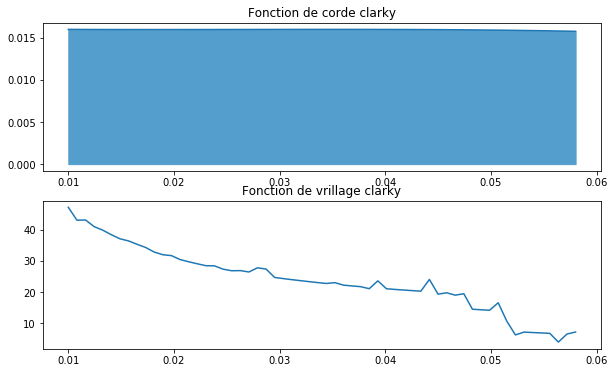

In [105]:
simu(naca = 'clarky', N_elements=60)

In [18]:
results = dict()

for naca in NACAS:
    rayons, res = simu(naca = naca, N_elements = 60)
    results[naca] = res

param defined, simu launched


KeyboardInterrupt: 

In [19]:
np.diff(np.array([1,3,9,2]))

array([ 2,  6, -7])

In [20]:
def simu_rayon(naca = '4412', N_elements = 50, r_min = 0.01):

    # Créations des fonctions continues Cx, Cz
    func_Cx = dict()
    func_Cz = dict()
    for reynolds in [50000, 100000, 200000, 500000, 1000000]:
        func_Cx[str(reynolds)] = Cx_spline(naca, reynolds)
        func_Cz[str(reynolds)] = Cz_spline(naca, reynolds)

    n = 10000/60

    # Vitesse de flux d'air en vol stat définie par Froude : (sqrt(mg/8rhoS) pour une hélice entière)

    def v_froude(r_max):
        return np.sqrt(0.5 * 9.81 / (8 * (r_max**2-r_min**2)* np.pi))

    # Angle dû à la vitesse "froude"

    def beta(r, r_max):
        angle_rad = np.arctan(v_froude(r_max)/(2*np.pi*n*r))
        angle_deg = angle_rad/np.pi*180
        return angle_deg

    # Fonction de vitesse
    def speed(r,r_max):
        v_t = 2*np.pi*r*n
        return np.sqrt(v_froude(r_max)**2+v_t**2)

    # Fonction de surface d'un trapèze
    def area(l1, l2, delta):
        return (np.abs(l1)+np.abs(l2))/2 * delta

    # Plus proche voisin d'un élément dans une liste

    def NN(element, L):
        l = len(L)
        cand = 0
        tol = np.abs(L[cand])+np.abs(element)
        for k in range(l):
            if np.abs(L[k]-element)<tol:
                cand = k
                tol = np.abs(L[k]-element)
        return cand

    # Fonction qui associe le Reynolds le plus proche du vrai Reynolds :

    def Reynolds(vitesse, L_c):
        mu = 1.56 * 10**-5
        all_reys = [50000,100000,500000,1000000]
        return all_reys[NN(L_c*vitesse/mu, all_reys)]

    # Calcul du Cx, Cz pour une géométrie donnée : 

    def C_global(thetas, chords, r_max, delta):
        sz = 0
        sx = 0
        div = 0
        for i in range(N_elements-1):
            v_i = speed(rayons[i],r_max)
            S_i = area(chords[i], chords[i+1], delta)
            reynolds = Reynolds(v_i, chords[i])
            C_x = func_Cx[str(reynolds)]
            sx+= v_i**2 * S_i * C_x(thetas[i]-beta(rayons[i],r_max))
            C_z = func_Cz[str(reynolds)]
            sz+= v_i**2 * S_i * C_z(thetas[i]-beta(rayons[i], r_max))

            div+= v_i**2 * S_i

        Cz = sz/div
        Cx = sx/div
        return Cz, Cx

    # Calcul du Cx induit pour une géométrie donnée :
    
    def C_induit(thetas, chords, r_max, delta, Cz):
        e = 0.8
        S_tot = 0
        for i in range(N_elements-1):
            c_i = chords[i]
            c_i2 = chords[i+1]
            S_tot+=area(c_i,c_i2, delta)

        allongement = (2*(r_max-r_min))**2 / S_tot
        C_xi = Cz**2/(np.pi * allongement * e)
        return C_xi
    # Calcul de la puissance de trainee (contrainte) :

    def puissance_trainee(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)
        r_max = args[-1]

        delta = (r_max - r_min)/N_elements

        P_tot = 0
        pho_air = 1.3
        S_tot = 0
        for i in range(N_elements-1):
            v_i = speed(rayons[i],r_max)
            S_i = area(chords[i],chords[i+1], delta)
            reynolds = Reynolds(v_i, chords[i])
            f_C_x = func_Cx[str(reynolds)]
            Cx_loc = f_C_x(thetas[i]-beta(rayons[i],delta))
            P_tot += 2 * 1/2 * pho_air * v_i**3 * Cx_loc * S_i
            S_tot += S_i

        Cz, Cx = C_global(thetas, chords, r_max, delta)
        C_xi = C_induit(thetas,chords, r_max, delta, Cz)
        v_moy = np.mean(speed(rayons,r_max))
        P_tot += 2 * 1/2 * pho_air * v_moy**3 * C_xi * S_tot
        return P_tot
    
    def puissance_poussee(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)
        r_max = args[-1]

        delta = (r_max-r_min)/N_elements

        P_tot = 0
        pho_air = 1.3
        for i in range(N_elements-1):
            v_i = speed(rayons[i],r_max)
            S_i = area(chords[i],chords[i+1],delta)
            reynolds = Reynolds(v_i, chords[i])
            f_C_z = func_Cz[str(reynolds)]
            Cz_loc = f_C_z(thetas[i]-beta(rayons[i],r_max))
            P_tot += 2 * 1/2 * pho_air * v_i**3 * Cz_loc * S_i
        return P_tot

    def puissance_totale(args):
        P = puissance_poussee(args) + puissance_trainee(args)
        return P

    def force_poussée(args):
        thetas = fonction_vrillage(args)
        chords = fonction_corde(args)
        r_max = args[-1]
    
        rayons = np.linspace(r_min, r_max, N_elements)
        delta = rayons[1] - rayons[0]

        F_tot = 0
        pho_air = 1.3

        Cz, Cx = C_global(thetas, chords, r_max, delta)

        for i in range(N_elements-1):
            v_i = speed(rayons[i],r_max)
            S_i = area(chords[i], chords[i+1],delta)
            reynolds = Reynolds(v_i, chords[i])
            f_C_z = func_Cz[str(reynolds)]
            Cz = f_C_z(thetas[i]-beta(rayons[i],r_max))
            F_tot+= 1/2 * pho_air * v_i**2 * S_i * Cz
        return 2* F_tot

    def fonction_vrillage(args):
        #return args[2] * rayons**2 + args[1] * rayons + args[0]
        return args[0:N_elements]
    
    def fonction_corde(args):
        #return args[-1] * rayons**3 + args[-2] * rayons**2 + args[-3] * rayons + args[-4]
        return args[N_elements:2*N_elements]

    def ray(args):
        return args[-1]

    def func2optim(args):
        return -force_poussée(args)

    # Création de la contrainte :

    cons1 = NonlinearConstraint(puissance_totale, 0, 60)

    cons2 = NonlinearConstraint(fonction_corde,np.ones(N_elements)*0.008,np.ones(N_elements)*0.014)

    cons3 = NonlinearConstraint(fonction_vrillage,np.zeros(N_elements),np.ones(N_elements)*60)

    mat = np.zeros((1,2*N_elements+1))
    mat[0][0] = 1

    cons4 = LinearConstraint(mat, 0.05, 0.08)

    # Initialisation des coefficients : 

    r_max_0 = [0.07]
    rayons_0 = np.linspace(r_min, r_max_0[0], N_elements)
    poly_vrillage_0 = [beta(rayons_0[k], r_max_0[0]) for k in range(N_elements)]
    poly_corde_0 = [0.02 for k in range(N_elements)]


    x_init = np.array(poly_vrillage_0+poly_corde_0 + r_max_0)

    # Exécution de l'optimisation :

    t_0 = time.time()

    opt = dict()
    opt['maxiter'] = 500
    opt['disp'] = True

    res = minimize(func2optim, x0 = x_init, constraints = [cons1], options = opt)

    print(f'Run {naca} in {int(time.time()-t_0)}s')
    print(res['success'], "in", res['nit'],"steps")

    r_max = res['x'][-1]
    rayons_aff = np.linspace(r_min, r_max, N_elements)

    fig, ax = plt.subplots(2,1, figsize=(10, 6))

    ax[0].plot(rayons_aff,fonction_corde(res['x']))
    ax[0].set_title('Fonction de corde')
    ax[0].axis('equal')
    ax[0].fill_between(rayons_aff, fonction_corde(res['x']), color='#539ecd')
    ax[1].set_title('Fonction de vrillage')
    ax[1].plot(rayons_aff,fonction_vrillage(res['x']))

    val = res['fun']
    print(f"Force de portance {-val}N")
    args = res['x']
    print(f"Puissance de trainée = {puissance_trainee(args)}W")
    print(f"Puissance de portance = {puissance_poussee(args)}W")
    print(f"Rayon max {r_max}")
    return rayons_aff, res

In [13]:
L_c = dict()
L_v = dict()
for naca in ['4415','4412']:
    with open(f'Optimresults/WithCxi/polyc{naca}.npy', 'rb') as file:
        L_c[naca] = np.load(file)
    with open(f'Optimresults/WithCxi/vrillage{naca}.npy','rb') as file:
        L_v[naca] = np.load(file)

In [14]:
def aff_res(naca):
    corde = L_c[naca]
    vrillage = L_v[naca]
    fig, ax = plt.subplots(2,1, figsize=(10, 6))
    ax[0].plot(corde)
    ax[1].plot(vrillage)

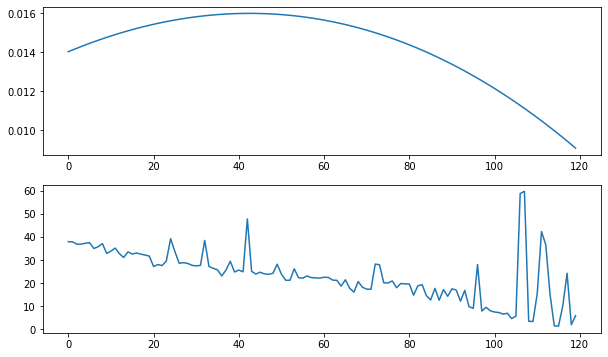

In [16]:
aff_res('4412')

In [21]:
L_v['4412']

array([37.92093623, 37.850603  , 36.84213005, 36.8444843 , 37.27515625,
       37.47658978, 34.97944777, 35.76623399, 37.08011441, 32.85120566,
       33.88881982, 35.16803697, 32.69132378, 31.1246722 , 33.52614293,
       32.57643642, 33.03681569, 32.57197988, 32.1312841 , 31.70634253,
       27.20637931, 28.03305639, 27.61465758, 29.61270767, 39.21229282,
       33.68436941, 28.60645647, 28.85529484, 28.55190876, 27.72775599,
       27.44683883, 27.71136923, 38.45537908, 27.20946393, 26.4259536 ,
       25.76549168, 23.1037677 , 25.7335729 , 29.45306818, 24.84114862,
       25.65752133, 24.91997277, 47.74790785, 25.09279265, 23.94106278,
       24.73741885, 24.01588137, 23.84919731, 24.25122897, 28.17686195,
       23.89653337, 21.25883918, 21.25547817, 26.19603561, 22.36443988,
       22.20000135, 23.09849086, 22.4126902 , 22.3030032 , 22.18873536,
       22.58419174, 22.47193081, 21.33124973, 21.23691043, 18.73428174,
       21.47769407, 17.84671319, 16.12005333, 20.69999576, 18.23

In [34]:
from scipy.interpolate import BarycentricInterpolator

In [35]:
f = BarycentricInterpolator(np.linspace(0.01,0.06,120),L_v['4412'])

C:\Users\eliel\Anaconda3\lib\site-packages\scipy\interpolate\polyint.py:638: RuntimeWarning: divide by zero encountered in true_divide
  p = np.dot(c,self.yi)/np.sum(c,axis=-1)[...,np.newaxis]


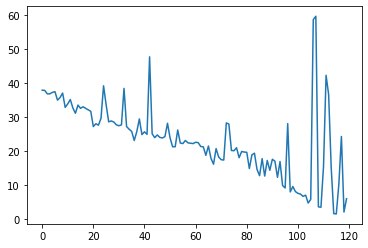

In [36]:
plt.plot(f(np.linspace(0.01,0.06,120)))

In [38]:
from scipy.signal import savgol_filter
W = savgol_filter(L_v['4412'], 11, 2)

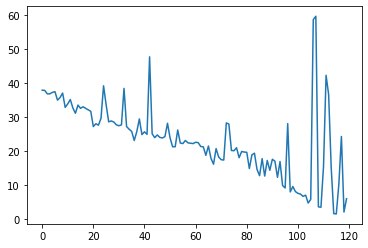

In [52]:
#plt.plot(W)
plt.plot(L_v['4412'])

In [60]:
def monotonic(A):
    l = len(A)
    w = np.zeros(l)
    w[0] = A[0]
    for k in range(1,l):
        if A[k] > w[k-1]:
            w[k] = w[k-1]
        else:
            w[k] = A[k]
    return w

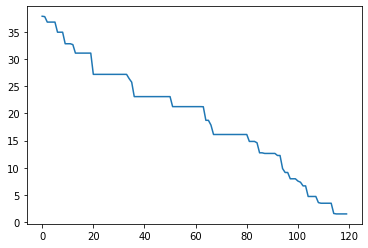

In [64]:
M = monotonic(L_v['4412'])
plt.plot(M)

In [87]:
from scipy.interpolate import UnivariateSpline

In [101]:
f = UnivariateSpline(np.arange(120),L_v['4412'], k =1)

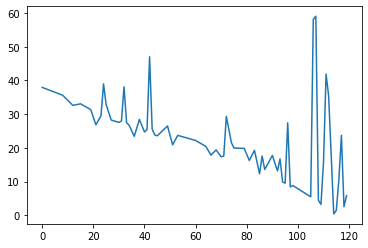

In [102]:
plt.plot(f(np.arange(120)))
#plt.plot(M)